In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tick.plot import plot_hawkes_baseline_and_kernels,plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, HawkesSumExpKern, HawkesEM
%matplotlib inline
import time
import simulationHawkes as sh
from joblib import Parallel, delayed
import SNHunivariate as snh
import NonHomogenousPoisonEstimation as nhp

%config Completer.use_jedi = False

## Mu Implementation for Varying Baseline

In [5]:

#Inflection Points for kernel
def inflectionPoints():
    dict1.clear()
    div = B[0]+epsilon*(np.abs(B[0])<epsilon)
    x = -B[1]/div
    interestX1 = x*(x>0)
   
    alwaysInclude = (x<=0)*(B[0]>0) #dont change
    alwaysExclude = (x<=0)*(B[0]<0)
    
    tempX = x*(~alwaysInclude)*(~alwaysExclude)
    interestX1 = tempX[interestX1>0]
    interestX = np.sort(interestX1)
    interestX = np.append(0,interestX)
    
    dict1['inflection']=interestX
    
    return

#combined Mu and Kernel
def nnMuKernel(x,diffx):

    c=musC[0]
    kernelSum=(nnKernel(diffx)).sum()
    muValue=(nnMufunction(x)).sum()
    y=max(muValue+kernelSum,0)+c
    return y



#Mu function
def nnMufunction(x):
    alpha0Mu=mus1[0]
    x=np.array(x)
    x=x.reshape(-1)

    y=np.ones(len(x))*alpha0Mu
    return y.reshape(-1)

#Kernel Calcualtion
def nnKernel(x):
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    n1 = np.maximum(betas*x.reshape(1,-1) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0

    return y

#integrated mu and kernel
def nnIntegrateMuKernel(iArray):
    IntegratedLambda=np.array(Parallel(n_jobs=50)(delayed(nnIntegratedParallel)(j) for j in np.nditer(iArray)),dtype=object)
    return IntegratedLambda.sum()

def nnIntegratedParallel(j):
    inflectionKernel=dict1['inflection']
    tj=t[j]
    if tj>0:
        iP=t[j-1]
        lj=max(0,j-support)
        temp=t[lj:j]
        inflectionPs=inflectionKernel+temp.reshape(-1,1)
        inflectionPs=inflectionPs.reshape(-1)
        inflectionPs=np.sort(inflectionPs)
        inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        IntegratedLambda=nnIntegrateMuKernelPart(tj,iP,temp,inflectionPs)
    else:
        IntegratedLambda=0
    return IntegratedLambda
            
def outerIps(inflectionPs,temp):
    alpha0Mu=mus1[0]
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    inflection=[]
    infl1=-100
    for j in range(1,len(inflectionPs)):
        iP1=inflectionPs[j]
        iP2=inflectionPs[j-1]
        v1=-alpha0Mu[0]
        v2=0
        
        n1=betas*(iP1-temp-epsilon).reshape(1,-1)+beta0
        dn1=(n1>0)
        v3=-len(temp)*alpha0[0]-(alphas*beta0*dn1).sum()+(alphas*betas*dn1*(temp).reshape(1,-1)).sum()
        v4=(alphas*betas*dn1).sum()
        infl=(v1+v3)/(v2+v4)
        if (iP1>infl) & (iP2<infl) &(infl1!=infl):
            infl1=infl
            inflection.append(infl)
    return np.array(inflection)

def lambdaVs(temp,inflectionPs):
    alpha0Mu=mus1[0]
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    n1=np.maximum(betas*(inflectionPs.reshape(-1,1)-temp).reshape(1,-1)+beta0,0)
    n2=np.sum(A[0]*n1,axis=0)+A[1]
    n2=n2.reshape(len(inflectionPs),len(temp))
    y=np.sum(n2,axis=1)+nnMufunction(inflectionPs)
    return y
    
def nnIntegrateMuKernelPart(tj,iP,temp,inflectionPs):
  
    alpha0Mu=mus1[0]
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    c=musC[0]
    inflectionKernel=dict1['inflection']
    lambdaValInfl=lambdaVs(temp,inflectionPs)
    
    
    if len(lambdaValInfl<=0)!=0:
        oIp=[]
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(oIp,temp)
        if len(outerInflections)!=0:
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)
    
    integral=0
    for k in range(1,len(inflectionPs)):
        iP1=inflectionPs[k]
        iP2=inflectionPs[k-1]
        Mn2=alpha0Mu
        
        n1=np.maximum(betas*(iP1-temp-epsilon).reshape(1,-1)+beta0,0)
        dn1=(n1>0)
        n2=(np.dot(alphas.T,n1)+alpha0).sum()
        
        dn2=((Mn2+n2)>0)
        if dn2!=0:
            term1Mu=alpha0Mu*iP1
            term2Mu=alpha0Mu*iP2
            temp1=(iP1-temp).reshape(1,-1)
            temp2=(iP2-temp).reshape(1,-1)
        
            term1Kernel=(alpha0*temp1+np.sum(alphas*temp1*(beta0+0.5*temp1*betas)*dn1,axis=0)).sum()
            term2Kernel=(alpha0*temp2+np.sum(alphas*temp2*(beta0+0.5*temp2*betas)*dn1,axis=0)).sum()
        
        
            integral+=(term1Mu+ term1Kernel-(term2Mu+ term2Kernel))*dn2+c*(iP1-iP2)
     
    return integral
        

   
    
#Mu and Kernel Likelihood
def nnLoglikelihoodCom(iArray):
    c=musC[0]
    ll=0
    start=time.time()
    llIn=nnIntegrateMuKernel(iArray)
    end=time.time()
    #print("time taken for integrated kernel",end-start)
    print("Integrated Part Mu and kernel ",llIn)
    ll=ll+llIn
    for i in range(1,len(t)):
        
        li = max(i-support,0)
        
        temp = t[i]-t[li:i]
        #temp1=tk-t[li:k]
        #temp1=temp1[temp1<=suprtTs]
        #temp=tk-temp1
        MuKernel=nnMuKernel(t[i],temp)

        logLam = -np.log(MuKernel)
      
        ll = ll+logLam
    print("log Part",ll-llIn.sum())
    return ll    


#Mu and Kernel combined Gradients
def gradientsMuKernel(iArray):
    alphasMu=mus1[0]
    alphas = A[0]
    gradA0Mu=0
    
    gradA=np.zeros((len(alphas),1))*0
    gradB=np.zeros((len(alphas),1))*0
    gradB0=np.zeros((len(alphas),1))*0
    gradA0=0
    gradC=0
    
    start=time.time()
    
    gradients=np.array(Parallel(n_jobs=50)(delayed(gradientsMuKernelParallel)(j) for j in np.nditer(iArray)),dtype=object)
    gradA0Mu+=(gradients[:,0]).sum()

        
    gradA+=(gradients[:,1]).sum()
    gradA0+=(gradients[:,2]).sum()
    gradB+=(gradients[:,3]).sum()
    gradB0+=(gradients[:,4]).sum()
    gradC+=(gradients[:,5]).sum()
    
    length=len(iArray)
        
    gradA0Mu=gradA0Mu/length
    gradA,gradA0,gradB,gradB0=gradA/length,gradA0/length,gradB/length,gradB0/length
    end=time.time()
    #print("for gradient calculation",end-start)
    mus1grad[0]=gradA0Mu


    gradC  = gradC/length
    
    A_grad[0] = gradA.astype('float32')
    A_grad[1] = gradA0
    B_grad[0] = gradB.astype('float32')
    B_grad[1] = gradB0.astype('float32')
    musCgrad[0]=gradC
    
    return

def gradientsMuKernelParallel(j):
    
    alpha0Mu=mus1[0]

    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    c=musC[0]
    tj=t[j]
    inflectionKernel=dict1['inflection']
    
    if tj>0:
        iP=t[j-1]
        lj=max(0,j-support)
        temp=t[lj:j]
      
        inflectionPs=inflectionKernel+temp.reshape(-1,1)
        inflectionPs=inflectionPs.reshape(-1)
        inflectionPs=np.sort(inflectionPs)
        inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        gradMu,gradKer,gradCn=gradientsMuKernelPart(tj,iP,inflectionPs,temp)
        gradA0Mu=gradMu[0]

        
        gradA=gradKer[0]
        gradA0=gradKer[1]
        gradB=gradKer[2]
        gradB0=gradKer[3]
        
        gradC=gradCn
        logPart=np.sum(nnMuKernel(tj,(tj-temp)))
        inverseLog=1/logPart
        Mn2=alpha0Mu
            
        n1=np.maximum(betas*(tj-temp).reshape(1,-1)+beta0,0)
        dn1=(n1>0)
        n2=np.dot(alphas.T,n1)+alpha0
        
        dn2=((n2+Mn2).sum()>0)
        if dn2!=0:
            
            gradA0Mu-=1*inverseLog*(dn2)

            gradA0-=(len(temp))*dn2*inverseLog
            gradA-=(np.sum(n1,axis=1)*dn2*inverseLog).reshape(-1,1)
            gradB-=(np.sum(alphas*(tj-temp).reshape(1,-1)*dn1,axis=1)*dn2*inverseLog).reshape(-1,1)
            gradB0-=(np.sum(alphas*dn1,axis=1)*dn2*inverseLog).reshape(-1,1)
            gradC-=(1*inverseLog)
    else:
        
        gradA=gradB=gradB0=np.zeros((len(alphas),1))
        gradA0=gradA0Mu=gradC=0
        
    return gradA0Mu,gradA,gradA0,gradB,gradB0,gradC
        

            

def gradientsMuKernelPart(tj,iP,inflectionPs,temp):
    alpha0Mu=mus1[0]
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    c=musC[0]
    inflectionKernel=dict1['inflection']
    lambdaValInfl=lambdaVs(temp,inflectionPs)
    
    oIp=[]
    if len(lambdaValInfl<=0)!=0:
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(oIp,temp)
        if len(outerInflections)!=0:
            print(inflectionPs,outerInflections)
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)

    gradA0Mu=0
    gradA=np.zeros((len(alphas),1))*0
    gradB=np.zeros((len(alphas),1))*0
    gradB0=np.zeros((len(alphas),1))*0
    gradA0=0
    gradC=0
    for k in range(1,len(inflectionPs)):
        iP1=inflectionPs[k]
        iP2=inflectionPs[k-1]
        Mn2=alpha0Mu
        
        n1=np.maximum(betas*(iP1-temp-epsilon).reshape(1,-1)+beta0,0)
        dn1=(n1>0)
  
        n2=(np.dot(alphas.T,n1)+alpha0).sum()
     
        dn2=((Mn2+n2)>0)
        
        if dn2!=0:
            gradA0Mu+=(iP1-iP2)*dn2
        
            temp1=(iP1-temp).reshape(1,-1)
            temp2=(iP2-temp).reshape(1,-1)
            ck1=(np.sum(temp1*(beta0+0.5*betas*temp1)*dn1,axis=1)).reshape(-1,1)
            ck2=(np.sum(temp2*(beta0+0.5*betas*temp2)*dn1,axis=1)).reshape(-1,1)
            gradA+= (ck1-ck2)*dn2
            gradA0+=(temp1-temp2).sum()*dn2
            gradB+=(np.sum((alphas*0.5*(temp1)**2-alphas*0.5*(temp2)**2)*(dn1),axis=1)*dn2).reshape(-1,1)
            gradB0+=(np.sum((alphas*temp1-alphas*temp2)*(dn1),axis=1)*dn2).reshape(-1,1)
            gradC+=(iP1-iP2)
    gradMu=[gradA0Mu]
    gradKer=[gradA,gradA0,gradB,gradB0]
    return gradMu,gradKer,gradC
    




## Plotting

In [6]:


#Plotting for kernel and lambda
def plotlambdas(mu_t):
    dx=0.01
    tseries= t
    lambda_value=[]
    time_intervals=[]
    lambda_nn=[]
    lambdas_1=[]
    for i in range(1,len(tseries[0:100]),1):
        lambdas=[]
        new_temp=np.linspace(tseries[i-1],tseries[i],1)
        li=max(0,i-support)
        temp=new_temp.reshape(-1,1)-tseries[li:i]

        if kerneltype==0:
            
            lambdas=mu_t+np.sum(alpha*np.exp(-beta*temp),axis=1)
          
        elif kerneltype==1:
            lambdas=mu_t+np.sum(alpha*beta*((delta<temp)*((delta+1/beta)>temp)),axis=1)
        elif kerneltype==2: 
            for j in range(len(temp)):
                lambda1=np.exp(mu_t)*np.prod(kernel1(alpha,beta,temp[j]))
                lambdas.append(lambda1)
        elif kerneltype==3:

            lambdas=np.maximum(mu_t+np.sum(alpha*np.exp(-beta*temp),axis=1),0)
        elif kerneltype==4:
            lambdas=mu_t+np.sum(alpha*(delta+temp)**(-beta),axis=1)
        elif kerneltype==5:
            lambdas=np.maximum(mu_t+np.sum((alpha-beta)*(temp>=1/delta)*(temp<1/alpha)+(delta-alpha)*(temp>=1/alpha)*(temp<1/(delta-beta)),axis=1),0)

        lambdann=[]
        for j in range(0,len(temp)):
            
            mu=np.sum(nnMufunction(new_temp[j]))
            
            lambdass=max(mu+np.sum(nnKernel(temp[j])),0)+musC[0]
            lambdann.append(lambdass)
        lambdann=np.array(lambdann)
        
        lambda_nn.append(lambdann)
        time_intervals.append(new_temp)
        lambda_value.append(lambdas)
    time_intervals=(np.array(time_intervals)).reshape(-1)
    lambda_value=(np.array(lambda_value)).reshape(-1)
    lambda_nn=(np.array(lambda_nn)).reshape(-1)
    #print(np.mean(lambda_nn))
    #print(tseries)
    plt.figure(figsize=(10,4))
    plt.plot(time_intervals,lambda_value,label="Real Intensity")
    plt.plot(time_intervals,lambda_nn,label="NNNH")
    plt.xlabel("t")
    plt.ylabel("$\lambda(t)$")
    plt.legend()
    plt.grid()
    plt.pause(0.0005)
    
    
  
    return lambda_nn

def plotKernels():
    temp1=np.arange(0,8,0.01)
    kernel=nnKernel(temp1)
    if kerneltype==0:
        ker=alpha*np.exp(-beta*temp1)
    elif kerneltype==1:
        ker=alpha*beta*((delta<temp1)*((delta+1/beta)>temp1))
    elif kerneltype==2:
        ker=(sh.kernel1(alpha,beta,temp1))
    elif kerneltype==3:
        ker=(alpha*np.exp(-beta*temp1))
    elif kerneltype==4:
        ker=alpha*(delta+temp1)**(-beta)
    elif kerneltype==5:
        ker=(alpha-beta)*(temp1>=1/delta)*(temp1<1/alpha)+(delta-alpha)*(temp1>=1/alpha)*(temp1<1/(delta-beta))
        
    plt.plot(temp1,ker,label="Real Kernel")
    plt.plot(temp1,kernel.reshape(-1),label="NNNH")
    plt.xlabel("t")
    plt.ylabel(r"$\phi(t)$")
    plt.pause(0.0005)
    

In [7]:
#Adam Optimizer 
def sgdNeuralHawkes(nEpochs,lr,lr_mu):
    
    
    lr2 =lr*0.1
    
    
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    
    optimalParams=[]
    optimalParams.append(A)
    optimalParams.append(B)
    optimalParams.append(mus1)
  
    m_t_A = np.zeros([nNeurons,1])
    m_t_A0 =0
    m_t_B= np.zeros([nNeurons,1])
    m_t_B0= np.zeros([nNeurons,1])

    v_t_A = np.zeros([nNeurons,1])
    v_t_A0 =0
    v_t_B= np.zeros([nNeurons,1])
    v_t_B0= np.zeros([nNeurons,1])

    count = 0
    

    m_t_A0_Mu = 0
    v_t_A0_Mu = 0
    
    m_t_C=0
    v_t_C=0
    stop_count=0

    for epochs in range(1,nEpochs+1,1):
                   
        rsample = np.random.choice(len(t),len(t),replace = True)
        for i in range(1,len(rsample),100):
       
            count=count+1 
            
            gradientsMuKernel(rsample[i:i+100])
     
            
            
            m_t_A = beta_1*m_t_A + (1-beta_1)*A_grad[0]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(A_grad[0]*A_grad[0])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[0] = A[0]-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*A_grad[1]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(A_grad[1]*A_grad[1])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[1] = A[1]-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon)
            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*B_grad[0]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(B_grad[0]*B_grad[0])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[0] = B[0]-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*B_grad[1]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(B_grad[1]*B_grad[1])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[1] = B[1]-(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
            
            


            
            m_t_A0_Mu = beta_1*m_t_A0_Mu + (1-beta_1)*mus1grad[0]	#updates the moving averages of the gradient
            v_t_A0_Mu = beta_2*v_t_A0_Mu + (1-beta_2)*(mus1grad[0]*mus1grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0_Mu = m_t_A0_Mu/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0_Mu = v_t_A0_Mu/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mus1[0]= mus1[0]-(lr_mu*m_cap_A0_Mu)/(np.sqrt(v_cap_A0_Mu)+epsilon)
            
            
            m_t_C = beta_1*m_t_C + (1-beta_1)*musCgrad[0]	#updates the moving averages of the gradient
            v_t_C = beta_2*v_t_C + (1-beta_2)*(musCgrad[0]*musCgrad[0])	#updates the moving averages of the squared gradient
            m_cap_C = m_t_C/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_C = v_t_C/(1-(beta_2**count))		#calculates the bias-corrected estimates
            musC[0]= musC[0]-(lr_mu*0.01*m_cap_C)/(np.sqrt(v_cap_C)+epsilon)
            musC[0]=max(1e-5,musC[0])
            
            inflectionPoints()
    


        error=nnLoglikelihoodCom(np.arange(0,len(t),1))
                 
        if(bestll > error):
            optimalParams.clear()
            optimalParams=list([A,B,mus1,musC])
            bestll=error
            stop_count=0
        else:
            stop_count+=1
        print(i,epochs,bestll,error,mus1[0],musC[0])   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
     
            
        plotKernels()
        
        plotlambdas(mu_t)
        if stop_count==50:
            break
    
       
    return optimalParams
    

#Initialization
def initializeMus(nNeurons1):
    c=np.random.uniform(0,1,1)[0]*0.01

    
    alpha0Mu=np.array([len(t)/tmax])
    #alpha0Mu=np.array([mu_t])
    mus1.append(alpha0Mu)
    musC.append(c)

    a2=0
    mus1grad.append(a2)
    musCgrad.append(0)
    return

    
#Initialization Kernel
def initializeParams(nNeurons):
    #alphas = np.array([0.21,-0.21]).reshape(-1,1)
    
    alphas = (np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.2
    alpha0 = np.random.uniform(0,1,1)*0.001
    
    #alphas=weight_exp.reshape(-1,1)
    #alpha0=bias_exp
    
    betas=(np.random.uniform(0,1,nNeurons)).reshape(-1,1)*-0.3
    #betas=np.array([1,1]).reshape(-1,1)
    #betas=weight_relu.reshape(-1,1)
    
   
    beta0 =(np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.3
    
    #beta0=np.array([-1,-2.5]).reshape(-1,1)
    #beta0=bias_relu.reshape(-1,1)

    A.append(alphas)
    B.append(betas)
    A.append(alpha0)
    B.append(beta0)
    A_grad.append(np.zeros([nNeurons,1]))
    A_grad.append(0)
    B_grad.append(np.zeros([nNeurons,1]))
    B_grad.append(np.zeros([nNeurons,1]))
    return


        

9979.716142631896 0.0
type, integrated part, likelihood
power 769.3181967406957
2407.43974582473


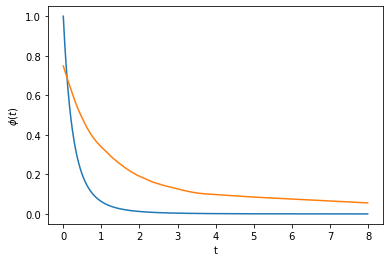

KeyboardInterrupt: 

In [10]:
mus1=[]

musC=[]
mus1grad=[]

musCgrad=[]
kerneltype=4
mutype=1
dictMus={}
dictIntegrate={}


dictgradient={}
epsilon = 1e-8

support=20
dict1={}
integratedDict={}



A=[]
B=[]
A_grad=[]
B_grad=[]
tseriesA = np.array([])

Dict_gradient={}


nNeurons=50
nNeurons1=50


alpha=1
beta=4
delta=1
mu_t=0.05
T=10000

if kerneltype==0:
    timevalue=sh.simu_univariate(alpha=alpha,beta=beta,T=T,mu=mu_t)
elif kerneltype==1:
    timevalue=sh.simu_tick_rect(alpha,delta,beta,mu_t,T=T)
    timevalue=timevalue[0]
    timevalue=np.append(0,timevalue)
elif kerneltype==2:
    timevalue=sh.simu_multiplicativeKernel(alpha,beta,mu_t,T)
elif kerneltype==3:
    timevalue=sh.simu_uniKernel_max(alpha=alpha,beta=beta,T=T,mu=mu_t)
elif kerneltype==4:
    timevalue=sh.simu_univariate_power(alpha,delta,beta,mu_t,T)
#plt.plot(timevalue,lambdavalue)
#plt.show()


t=np.array(timevalue)

tmax=t[-1]
tmin=t[0]
print(tmax,tmin)

if kerneltype==0:
    print(sh.loglikelihoodpara([alpha,beta,mu_t],t=t,integratedKernel=True))
elif kerneltype==1:
    print(sh.loglikelihood_rect(para=[alpha,beta,delta,mu_t],t=t,integratedKernel=True))
elif kerneltype==2:
    print(sh.loglikelihoodpara1(para=[alpha,beta,mu_t],t=t,integratedKernel=True))
elif kerneltype==3:
    print(sh.loglikelihoodpara_max(para=[alpha,beta,mu_t],t=t,integratedKernel=True))
    
elif kerneltype==4:
    print(sh.loglikelihood_power([alpha,delta,beta,mu_t],t,integratedKernel=True))
    

initializeParams(nNeurons)
initializeMus(nNeurons1)
plotKernels()

inflectionPoints()

optimalParams=sgdNeuralHawkes(250,0.004,0.008)



In [46]:

adjacency=alpha
decay=beta
period_length=3000
n_baselines=3000

baselines=mu_t*np.ones(period_length)
learner = HawkesSumExpKern(decays=np.array([decay]), n_baselines=n_baselines,
                           period_length=period_length,max_iter=500)

learner.fit([np.array(t)])



em = HawkesEM(1, kernel_size=32, n_threads=40, verbose=False, tol=1e-3)
em.fit([np.array(t)])
x_values=np.arange(0,5,0.01)
EMKernelValues=em.get_kernel_values(0,0,x_values)

optimalParamsNew=snh.sgdNeuralHawkes(500,0.01,np.random.uniform(0,1,1),np.array(timevalue))

1501 1 [9059.06697119] [9059.06697119] [0.8782658]
1501 2 [8796.37959169] [8796.37959169] [0.84908024]
1501 3 [8546.79492681] [8546.79492681] [0.82030763]
1501 4 [8302.24728128] [8302.24728128] [0.79143589]
1501 5 [8055.6610226] [8055.6610226] [0.76176119]
1501 6 [7833.04251294] [7833.04251294] [0.73459213]
1501 7 [7606.98989915] [7606.98989915] [0.70658266]
1501 8 [7387.50495436] [7387.50495436] [0.67901055]
1501 9 [7170.25602672] [7170.25602672] [0.65133494]
1501 10 [6960.45521835] [6960.45521835] [0.62422311]
1501 11 [6743.01643335] [6743.01643335] [0.59568334]
1501 12 [6545.24176676] [6545.24176676] [0.56929338]
1501 13 [6353.98555963] [6353.98555963] [0.54333885]
1501 14 [6159.5639328] [6159.5639328] [0.51646012]
1501 15 [5981.25457626] [5981.25457626] [0.49132038]
1501 16 [5788.98704548] [5788.98704548] [0.46356889]
1501 17 [5617.04249886] [5617.04249886] [0.43810388]
1501 18 [5447.77581304] [5447.77581304] [0.41233843]
1501 19 [5291.60051565] [5291.60051565] [0.38784566]
1501 20

1501 156 [3493.15710402] [3511.55093938] [0.05098136]
1501 157 [3493.15710402] [3499.66693443] [0.04918662]
1501 158 [3493.15710402] [3501.0040702] [0.04907406]
1501 159 [3493.15710402] [3503.32436592] [0.05058037]
1501 160 [3493.15710402] [3516.78342775] [0.04936272]
1501 161 [3493.15710402] [3501.92054635] [0.05002045]
1501 162 [3493.15710402] [3502.64944781] [0.05221005]
1501 163 [3493.15710402] [3501.00409181] [0.04958811]
1501 164 [3493.15710402] [3505.25509448] [0.04814148]
1501 165 [3493.15710402] [3505.97826155] [0.04978243]
1501 166 [3493.15710402] [3515.55404958] [0.04950821]
1501 167 [3493.15710402] [3499.3894564] [0.04935341]
1501 168 [3493.15710402] [3500.81464121] [0.04926717]
1501 169 [3493.15710402] [3499.44397205] [0.04837691]
1501 170 [3493.15710402] [3501.97572995] [0.04908026]
1501 171 [3493.15710402] [3501.5596541] [0.04978364]
1501 172 [3493.15710402] [3499.61224427] [0.04822059]
1501 173 [3493.15710402] [3500.5786949] [0.04955283]
1501 174 [3493.15710402] [3499.3

1501 309 [3493.15710402] [3516.14850217] [0.05024524]
1501 310 [3493.15710402] [3521.73720349] [0.05109852]
1501 311 [3493.15710402] [3529.96728255] [0.05052067]
1501 312 [3493.15710402] [3513.59866953] [0.05135845]
1501 313 [3493.15710402] [3514.72039204] [0.04954342]
1501 314 [3493.15710402] [3514.2586796] [0.04799201]
1501 315 [3493.15710402] [3513.89190503] [0.04988097]
1501 316 [3493.15710402] [3517.59549385] [0.04925571]
1501 317 [3493.15710402] [3514.71045105] [0.0477495]
1501 318 [3493.15710402] [3520.69993991] [0.04794506]
1501 319 [3493.15710402] [3514.06873258] [0.0496061]
1501 320 [3493.15710402] [3523.63417064] [0.04952357]
1501 321 [3493.15710402] [3514.59359906] [0.04970684]
1501 322 [3493.15710402] [3520.89170139] [0.05148665]
1501 323 [3493.15710402] [3513.62223621] [0.04876538]
1501 324 [3493.15710402] [3518.2662325] [0.04576757]
1501 325 [3493.15710402] [3514.63630808] [0.04554876]
1501 326 [3493.15710402] [3513.24876082] [0.04938091]
1501 327 [3493.15710402] [3514.9

1501 462 [3476.42353128] [3476.70938462] [0.04723124]
1501 463 [3476.34995483] [3476.34995483] [0.04797519]
1501 464 [3476.34995483] [3476.39924955] [0.04870088]
1501 465 [3475.49616373] [3475.49616373] [0.0483326]
1501 466 [3475.49616373] [3476.25936937] [0.04774644]
1501 467 [3475.49616373] [3485.13769026] [0.0495272]
1501 468 [3475.49616373] [3477.16791882] [0.04973019]
1501 469 [3475.49616373] [3481.27465876] [0.04478187]
1501 470 [3475.49616373] [3481.83039306] [0.04875958]
1501 471 [3475.49616373] [3475.68414546] [0.04656118]
1501 472 [3475.49616373] [3481.40791718] [0.04879416]
1501 473 [3475.49616373] [3478.18386902] [0.04838823]
1501 474 [3475.49616373] [3482.59832755] [0.04991696]
1501 475 [3475.39497627] [3475.39497627] [0.04781815]
1501 476 [3475.39497627] [3482.76709598] [0.04764751]
1501 477 [3475.39497627] [3501.13789897] [0.04644446]
1501 478 [3475.39497627] [3496.37168535] [0.04871337]
1501 479 [3475.39497627] [3475.62189066] [0.05140097]
1501 480 [3475.39497627] [3481

In [50]:
SumExpKernel=learner.get_kernel_values(0,0,x_values)
SNHKernel_values=snh.optimalKernel(x_values.reshape(1,-1))
#realKernel=alpha*(delta+x_values)**(-beta)
realKernel=alpha*beta*((delta<x_values)*((delta+1/beta)>x_values))
#realKernel=alpha*np.exp(-beta*x_values)
intervals=np.arange(0,period_length,1)
muSNH=optimalParamsNew[3]
muEM=em.baseline
interval1=np.arange(0,3000,100)
bl=learner.baseline[0,[interval1]]


In [51]:
kernelNew=optimalKernel(x_values)
MuNew=mus1[0]*np.ones(len(interval1)*100)
MuNew

array([0.05742698, 0.05742698, 0.05742698, ..., 0.05742698, 0.05742698,
       0.05742698])

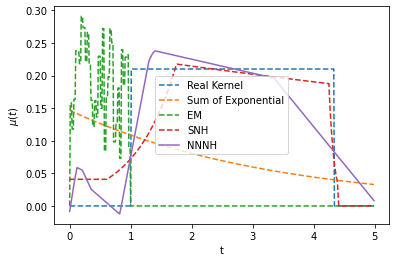

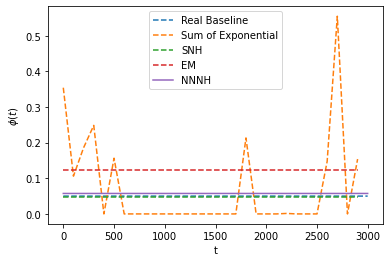

In [52]:
plt.plot(x_values,realKernel,"--",label="Real Kernel")
plt.plot(x_values,SumExpKernel,"--",label="Sum of Exponential")

plt.plot(x_values,EMKernelValues,"--",label="EM")
plt.plot(x_values,SNHKernel_values.reshape(-1),"--",label="SNH")
plt.plot(x_values,kernelNew.reshape(-1),label="NNNH")
plt.xlabel("t")
plt.ylabel(r"$\mu(t)$")
plt.legend()
plt.savefig('results_MSNH/rectKernel_constantmuKernel')
plt.show()


plt.plot(intervals,baselines,"--",label="Real Baseline")
plt.plot(interval1,bl[0],"--",label="Sum of Exponential")

plt.plot(interval1,np.ones(len(interval1))*muEM,"--",label="EM")
plt.plot(interval1,np.ones(len(interval1))*muSNH,"--",label="SNH")
plt.plot(intervals,MuNew,label="NNNH")
plt.xlabel("t")
plt.ylabel(r"$\phi(t)$")
plt.legend()
plt.savefig('results_MSNH/rectKernel_constantmuMu')
